In [1]:
# Pickle
import pickle

# Low-level utils
import numpy as np
from scipy.sparse import csr_matrix

# Data Vizualizations
import seaborn as sns

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# SK-Learn Classifiers
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

# Model Selection
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV

# Metrics
from sklearn.metrics import classification_report, accuracy_score

# XGBoost
import xgboost as xgb

# my utils
from load_utils.load import *
from nlp_utils.nlp import *

In [2]:
DIR = "/Users/victor/Desktop/OldAndBald/app/data/"

# Data Loading into Data Frame

In [3]:
data = text2array("sentiment.txt")
yelp = text2array("yelp.txt", is_yelp=True)
amazon = text2array("amazon.txt", is_yelp=True)
imdb = text2array("imdb.txt", is_yelp=True)

data = array2df([*data, *yelp, *amazon, *imdb])

In [4]:
data.head()

,text,label
0,The Da Vinci Code book is just awesome.\n,1
1,this was the first clive cussler i've ever rea...,1
2,i liked the Da Vinci Code a lot.\n,1
3,i liked the Da Vinci Code a lot.\n,1
4,I liked the Da Vinci Code but it ultimatly did...,1


# Natural Language Processing

## Standartizing

In [5]:
standartize(data)

## Remove Noise

In [6]:
remove_noise(data)

## Lemmatizing / Stemming

In [7]:
# lemmatize(data)
stem(data)

## Save data

In [8]:
data.to_csv(DIR+"final.csv")

# Exploratory Data Analysis

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10086 entries, 0 to 10085
Data columns (total 2 columns):
text     10086 non-null object
label    10086 non-null object
dtypes: object(2)
memory usage: 157.7+ KB


In [10]:
data.describe()

,text,label
count,10086,10086
unique,4095,2
top,da vinci code suck,1
freq,344,5495


In [11]:
data.head()

,text,label
0,da vinci code book just awesom,1
1,wa first clive cussler have ever read even boo...,1
2,like da vinci code lot,1
3,like da vinci code lot,1
4,like da vinci code ultimatli not seem hold it is,1


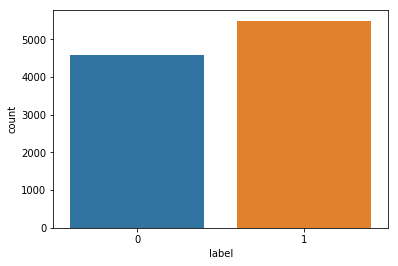

In [12]:
sns.countplot(data["label"]);

# Feature Extraction

In [13]:
X, y = data["text"], data["label"]

In [14]:
tfidf = TfidfVectorizer().fit(X, y)
X_tf = tfidf.transform(X)

In [15]:
X_tf

<10086x5012 sparse matrix of type '<class 'numpy.float64'>'
	with 73458 stored elements in Compressed Sparse Row format>

In [16]:
with open("/Users/victor/Desktop/OldAndBald/app/nlp_utils/tf_idf.pickle", mode="wb") as f:
    pickle.dump(tfidf, f)

# Model testing

In [17]:
def test_model(model, X=X_tf, y=y, cv=10):
    score = cross_validate(model, X, y, scoring="accuracy", cv=cv)
    return np.mean(score["test_score"])

def test_non_sk_model(model, X=X_tf, y=y, cv=10):
    res = 0.00
    
    for _ in range(cv):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        res += accuracy_score(y_test, y_pred)
        
    return res / cv

## Several models testing

In [18]:
# test_model(BernoulliNB()) -> 0.8909900150959453

In [19]:
# test_model(DecisionTreeClassifier()) -> 0.8976388067271968

In [20]:
# test_model(LogisticRegression()) -> 0.9161835130844247

In [21]:
# test_model(KNeighborsClassifier()) -> 0.873157933891223

In [22]:
# test_model(AdaBoostClassifier(DecisionTreeClassifier())) -> 0.9049807650133553

In [23]:
# test_model(RandomForestClassifier()) -> 0.8829702279126398

In [24]:
# test_model(xgb.XGBClassifier()) -> 0.8733309905569347

## Gradient search (fit the hyper-parameters)

In [24]:
g_search_nb = GridSearchCV(
    BernoulliNB(),
    param_grid={
        "alpha": [0.01, 0.03, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
        "binarize": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    },
    scoring="accuracy",
    cv=3
).fit(X_tf, y)

(g_search_nb.best_score_, g_search_nb.best_params_)

(0.7326987904025382, {'alpha': 0.03, 'binarize': 0.1})

In [25]:
g_search_lg = GridSearchCV(
    LogisticRegression(dual=True),
    param_grid={
        "C": [0.01, 0.03, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    },
    scoring="accuracy",
    cv=3
).fit(X_tf, y)

(g_search_lg.best_score_, g_search_lg.best_params_)

(0.8445369819551855, {'C': 1.0})

In [26]:
g_search_tree = GridSearchCV(
    DecisionTreeClassifier(criterion="gini"),
    param_grid={
        "max_depth": range(5, 100),
    },
    scoring="accuracy",
    cv=3
).fit(X_tf, y)

(g_search_tree.best_score_, g_search_tree.best_params_)

(0.8399762046400951, {'max_depth': 97})

## Train-Test split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_tf, y)

# MyMode (model weighting)

In [26]:
from main.algo import MyModel

## Naive Cross-validation like test for MyModel

In [27]:
test_non_sk_model(
    MyModel(
        BernoulliNB(alpha=1.0),
        BernoulliNB(alpha=1.0),
        LogisticRegression(C=1.0, dual=True),
        DecisionTreeClassifier(max_depth=100),
    )
)

0.9287473715830579

## MyModel test on train-test split

In [28]:
my_model = MyModel(
    BernoulliNB(alpha=1.0),
    BernoulliNB(alpha=1.0),
    LogisticRegression(C=1.0, dual=True),
    DecisionTreeClassifier(max_depth=100),
    # AdaBoostClassifier(DecisionTreeClassifier())
).fit(X_train, y_train)

In [29]:
y_pred = my_model.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.94      0.91      0.92      1153
          1       0.92      0.95      0.94      1369

avg / total       0.93      0.93      0.93      2522



In [30]:
my_model.predict_proba(X_test[1])

[array([[0.01484141, 0.98515859]])]

## Save MyModel to pickle file

In [31]:
my_model = MyModel(
    BernoulliNB(alpha=1.0),
    BernoulliNB(alpha=1.0),
    LogisticRegression(C=1.0, dual=True),
    DecisionTreeClassifier(max_depth=100),
).fit(X_tf, y)

In [32]:
with open("/Users/victor/Desktop/OldAndBald/app/main/sentiment_algo.pickle", mode="wb") as f:
    pickle.dump(my_model, f)

In [33]:
pickle.load(open("/Users/victor/Desktop/OldAndBald/app/main/sentiment_algo.pickle", mode="rb"))